<a href="https://colab.research.google.com/github/sehan25/ESAA-2022-2/blob/main/Assignment/1111-Python-machine-learning-ch08-document-clustering%2B%2Bpractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **07. 문서 군집화 소개와 실습(Opinion Review 데이터 세트)**

### 문서 군집화 개념
- 문서 군집화(Document Clustering): 비슷한 텍스트 구성의 문서를 군집화(Clustering)하는 것
- 동일한 군집에 속하는 문서를 같은 카테고리 소속으로 분류할 수 있으므로 앞에서 소개한 텍스트 분류 기반의 문서 분류와 유사함
- 텍스트 분류 기반의 문서 분류는 사전에 결정 카테고리 값을 가진 학습 데이터 세트가 필요한 데 반해, 문서 군집화는 학습 데이터 세트가 필요 없는 비지도학습 기반으로 동작함

### Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기
- 여러 개의 파일을 한 개의 DataFrame으로 로딩해 데이터 처리하고자 함
- 먼저 해당 디렉터리 내의 모든 파일에 대해 각각 for 반복문으로 반복하면서 개별 파일명을 파일명 리스트에 추가하고 개별 파일은 DataFrame으로 읽은 후 다시 문자열로 반환한 뒤 파일 내용 리스트에 추가

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import glob ,os

path = r'/content/drive/MyDrive/ESAA/data/OpinosisDataset1.0/topics'                 
# path로 지정한 디렉토리 밑에 있는 모든 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일들의 파일명은 filename_list 리스트로 취합, 
# 개별 파일들의 파일내용은 DataFrame로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취합 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_, index_col=None, header=0, encoding='latin1')
    
    filename_ = file_.split('/')[-1]
    filename = filename_.split('.')[0]

    #파일명 리스트와 파일내용 리스트에 파일명과 파일 내용을 추가. 
    filename_list.append(filename)
    opinion_text.append(df.to_string())

# 파일명 리스트와 파일내용 리스트를  DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,display_garmin_nuvi_255W_gps,...
1,battery-life_netbook_1005ha,...
2,battery-life_ipod_nano_8gb,...
3,buttons_amazon_kindle,...
4,eyesight-issues_amazon_kindle,...


- 문서를 TF-IDF 형태로 피처 벡터화
    - `tokenizer()`는 이전 예제에서 Lemmatization을 구현한 `LemNormalize()` 함수 이용
    - TfidfVectorizer의 `fit_transform()`의 인자로 document_df DataFrame의 opinion_text 칼럼을 입력하면 개별 문서 텍스트에 대해 TF-IDF 변환된 피처 벡터화된 행렬 구할 수 있음

In [10]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [11]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english',
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

# opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


- 문서별 텍스트가 TF-IDF 변환된 피처 벡터화 행렬 데이터에 대해서 군집화 수행해 어떤 문서끼리 군집되는지 확인
    - 군집화 기법은 K-평균 적용
    - 문서의 유형은 크게 보자면, 전자제품, 자동차, 호텔로 돼 있음
        - 전자 제품은 다시 네비게이션, 아이팟, 킨들, 랩탑 컴퓨터 등과 같은 세부 요소로 나뉨
- 먼저 5개의 중심(Centroid) 기반으로 어떻게 군집화되는지 확인

In [19]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

- 각 데이터별로 할당된 군집의 레이블을 파일명과 파일 내용을 가지고 있는 document_df DataFrame에 'cluster_label' 칼럼을 추가해 저장
- 군집이 각 주제별로 유사한 형태로 잘 구성됐는지 알아보기

In [20]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,display_garmin_nuvi_255W_gps,...,0
1,battery-life_netbook_1005ha,...,3
2,battery-life_ipod_nano_8gb,...,3
3,buttons_amazon_kindle,...,4
4,eyesight-issues_amazon_kindle,...,4


- document_df DataFrame 객체에서 cluster_label로 어떤 파일명으로 매칭됐는지 보면서 군집화 결과 확인

In [21]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
6,accuracy_garmin_nuvi_255W_gps,...,0
11,directions_garmin_nuvi_255W_gps,...,0
0,display_garmin_nuvi_255W_gps,...,0
20,satellite_garmin_nuvi_255W_gps,...,0
44,speed_garmin_nuvi_255W_gps,...,0
46,speed_windows7,...,0
21,updates_garmin_nuvi_255W_gps,...,0


&rarr; Cluster#1은 킨들, 아이팟, 넷북이 군집에 포함돼 있지만, 주로 차량용 네비게이션으로 군집이 구성돼 있음

In [16]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
10,comfort_honda_accord_2008,...,1
7,comfort_toyota_camry_2007,...,1
47,gas_mileage_toyota_camry_2007,...,1
36,interior_honda_accord_2008,...,1
27,interior_toyota_camry_2007,...,1
29,mileage_honda_accord_2008,...,1
30,performance_honda_accord_2008,...,1
33,quality_toyota_camry_2007,...,1
26,seats_honda_accord_2008,...,1
37,transmission_toyota_camry_2007,...,1


&rarr; Cluster #1을 살펴보면 토요타(Toyota)와 혼다(Honda) 등의 자동차에 대한 리뷰로 잘 군집화돼 있음

In [17]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
5,bathroom_bestwestern_hotel_sfo,...,2
50,food_holiday_inn_london,...,2
34,food_swissotel_chicago,...,2
14,free_bestwestern_hotel_sfo,...,2
13,location_bestwestern_hotel_sfo,...,2
16,location_holiday_inn_london,...,2
42,parking_bestwestern_hotel_sfo,...,2
12,price_holiday_inn_london,...,2
23,room_holiday_inn_london,...,2
18,rooms_bestwestern_hotel_sfo,...,2


&rarr; Cluster #0은 호텔에 대한 리뷰로 군집화돼 있음

In [23]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
8,battery-life_amazon_kindle,...,3
2,battery-life_ipod_nano_8gb,...,3
1,battery-life_netbook_1005ha,...,3
40,performance_netbook_1005ha,...,3
15,sound_ipod_nano_8gb,headphone jack i got a clear case for it a...,3


&rarr; Cluster #3은 킨들, 아이팟, 넷북 등의 포터블 전자기기에 대한 리뷰로 군집화돼 있음

In [24]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
3,buttons_amazon_kindle,...,4
4,eyesight-issues_amazon_kindle,...,4
9,features_windows7,...,4
43,fonts_amazon_kindle,...,4
35,keyboard_netbook_1005ha,...,4
19,navigation_amazon_kindle,...,4
17,price_amazon_kindle,...,4
45,screen_garmin_nuvi_255W_gps,...,4
25,screen_ipod_nano_8gb,...,4
49,screen_netbook_1005ha,...,4


&rarr; Cluster #4는 킨들, 아이팟, 넷북 등의 포터블 전자기기에 대한 리뷰로 군집화돼 있음

- 전반적으로 군집화된 결과를 살펴보면 군집 개수가 약간 많게 설정돼 있어서 세분화되어 군집화된 경향이 있음
- 중심 개수를 5개에서 3개로 낮춰서 3개 그룹으로 군집화한 뒤 결과 확인

In [29]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

# 소속 군집을 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
0,display_garmin_nuvi_255W_gps,...,0
46,speed_windows7,...,0
45,screen_garmin_nuvi_255W_gps,...,0
44,speed_garmin_nuvi_255W_gps,...,0
43,fonts_amazon_kindle,...,0
40,performance_netbook_1005ha,...,0
38,video_ipod_nano_8gb,...,0
35,keyboard_netbook_1005ha,...,0
28,voice_garmin_nuvi_255W_gps,...,0
49,screen_netbook_1005ha,...,0


In [34]:
document_df[document_df['cluster_label']==0].sort_values(by='filename') #포터블 전자기기 리뷰

,filename,opinion_text,cluster_label
6,accuracy_garmin_nuvi_255W_gps,...,0
8,battery-life_amazon_kindle,...,0
2,battery-life_ipod_nano_8gb,...,0
1,battery-life_netbook_1005ha,...,0
3,buttons_amazon_kindle,...,0
11,directions_garmin_nuvi_255W_gps,...,0
0,display_garmin_nuvi_255W_gps,...,0
4,eyesight-issues_amazon_kindle,...,0
9,features_windows7,...,0
43,fonts_amazon_kindle,...,0


In [30]:
document_df[document_df['cluster_label']==1].sort_values(by='filename') #자동차 리뷰

,filename,opinion_text,cluster_label
10,comfort_honda_accord_2008,...,1
7,comfort_toyota_camry_2007,...,1
47,gas_mileage_toyota_camry_2007,...,1
36,interior_honda_accord_2008,...,1
27,interior_toyota_camry_2007,...,1
29,mileage_honda_accord_2008,...,1
30,performance_honda_accord_2008,...,1
33,quality_toyota_camry_2007,...,1
26,seats_honda_accord_2008,...,1
37,transmission_toyota_camry_2007,...,1


In [31]:
document_df[document_df['cluster_label']==2].sort_values(by='filename') #호텔 리뷰

,filename,opinion_text,cluster_label
5,bathroom_bestwestern_hotel_sfo,...,2
50,food_holiday_inn_london,...,2
34,food_swissotel_chicago,...,2
14,free_bestwestern_hotel_sfo,...,2
13,location_bestwestern_hotel_sfo,...,2
16,location_holiday_inn_london,...,2
42,parking_bestwestern_hotel_sfo,...,2
12,price_holiday_inn_london,...,2
23,room_holiday_inn_london,...,2
18,rooms_bestwestern_hotel_sfo,...,2


### 군집별 핵심 단어 추출하기
- KMeans 객체는 각 군집을 구성하는 단어 피처가 군집의 중심(Centroid)을 기준으로 얼마나 가깝게 위치해 있는지 cluster_centers_라는 속성으로 제공함
    - clsuter_centers_: 배열 값으로 제공되며, 행은 개별 군집을, 열은 개별 피처를 의미
    - 각 배열 내의 값은 개별 군집 내의 상대 위치를 숫자 값으로 표현한 일종의 좌표 값

In [35]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape: ',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape:  (3, 4611)
[[0.01005322 0.         0.         ... 0.00706287 0.         0.        ]
 [0.         0.00092551 0.         ... 0.         0.         0.        ]
 [0.         0.00099499 0.00174637 ... 0.         0.00183397 0.00144581]]


&rarr; 군집이 3개, word 피처가 2409개로 구성되었음을 의미  
-  각 행의 배열 값은 각 군집 내의 2409개 피처의 위치가 개별 중심과 얼마나 가까운가를 상대 값으로 나타낸 것
    - 0에서 1까지의 값을 가질 수 있으며 1에 가까울수록 중심과 가까운 값을 의미
- cluster_centers 속성값을 이용해 각 군집별 핵심 단어 찾아보기
    - `ndarray의 argsort()[:, :: -1]`를 이용하면 cluster_centers 배열 내 값이 큰 순으로 정렬된 위치 인덱스 값을 반환
    - 이 위치 인덱스 값이 필요한 이유는 핵심 단어 피처의 이름을 출력하기 위해서임
- 새로운 함수 `get_cluster_details()`를 생성해 위에 대한 처리를 담당
    - cluster_centers 배열 내에서 가장 값이 큰 데이터의 위치 인덱스를 추출한 뒤, 해당 인덱스를 이용해 핵심 단어 이름과 그때의 상대 위치 값을 추출해 cluster_details라는 Dict 객체 변수에 기록하고 반환하는 것이 주요 로직


In [36]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상댓값, 대상 파일명들을 반환함
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num,
                        top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array의 값이 큰 순으로 정렬된 인덱스 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    # 개별 군집별로 반복하면서 핵심 단어, 그 단어의 중심 위치 상댓값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 인덱스를 이용하여 top n 피처 단어를 구함
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

- `get_cluster_details()`를 호출하면 dictionary를 원소로 가지는 리스트인 cluster_details를 반환
- 이 cluster_details에는 개별 군집번호, 핵심 단어, 핵심단어 중심 위치 상댓값, 파일명 속성 값 정보가 있는데, 이를 좀 더 보기 좋게 표현하기 위해서 별도의 `print_cluster_details()` 함수 생성

In [38]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명: ', cluster_detail['filenames'][:7])
        print('================================================')

- 위에서 생성한 `get_cluster_details()`, `print_cluster_details()` 호출
- `get_cluster_details()` 호출 시 인자는 KMeans 군집화 객체, 파일명 추출을 위한 document_df DataFrame, 핵심 단어 추출을 위한 피처명 리스트, 전체 군집 개수, 그리고 핵심 단어 추출 개수
- 피처명 리스트는 앞에서 TF-IDF 변환된 tfidf_vect 객체에서 `get_feature_names()`로 추출

In [39]:
feature_names = tfidf_vect.get_feature_names()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,
                                  feature_names=feature_names, clusters_num=3, top_n_features=10)
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명:  ['display_garmin_nuvi_255W_gps', 'battery-life_netbook_1005ha', 'battery-life_ipod_nano_8gb', 'buttons_amazon_kindle', 'eyesight-issues_amazon_kindle', 'accuracy_garmin_nuvi_255W_gps', 'battery-life_amazon_kindle']
####### Cluster 1
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명:  ['comfort_toyota_camry_2007', 'comfort_honda_accord_2008', 'seats_honda_accord_2008', 'interior_toyota_camry_2007', 'mileage_honda_accord_2008', 'performance_honda_accord_2008', 'quality_toyota_camry_2007']
####### Cluster 2
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명:  ['bathroom_bestwestern_hotel_sfo', 'price_holiday_inn_london', 'location_bestwestern_hotel_sfo', 'free_bestwestern_h

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## **10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge**
- Mercari Price Suggestion Challenge는 캐글에서 진행된 Challenge로서, 일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격을 예측하는 과제
- 제공되는 데이터 세트는 제품에 대한 여러 속성 및 제품 설명 등의 텍스트 데이터로 구성됨
    - train_id: 데이터 id
    - name: 제품명
    - item_condition_id: 판매자가 제공하는 제품 상태
    - category_name: 카테고리 명
    - brand_name: 브랜드 이름
    - price: 제품 가격, 예측을 위한 타깃 속성
    - shipping: 배송비 무료 여부, 1이면 무료(판매자가 지불), 0이면 유료(구매자 지불)
    - item_description: 제품에 대한 설명
- 회귀로 피처를 학습한 뒤 price를 예측하는 문제
- Mercari Price Suggestion이 기존 회귀 예제왇 다른 점은 item_description과 같은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점

### 데이터 전처리

In [44]:
from sklearn.linear_model import Ridge , LogisticRegression
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
import pandas as pd

mercari_df= pd.read_csv('/content/drive/MyDrive/ESAA/data/kaggle/mercari-price-suggestion-challenge/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [45]:
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


&rarr; brand name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 돼 있음  
&rarr; item_ desciption의 null 값은 4건으로 미비함. 이 Null 데이터는 이후에 적절한 문자열로 치환함  
- Target 값인 price 칼럼의 데이터 분포도 살펴보기
    - 회귀에서 Target 값의 정규 분포도는 매우 중요함
    - 왜곡돼 있을 경우 보통 로그를 씌워서 변환하면 대부분 정규 분포의 형태를 가지게 됨

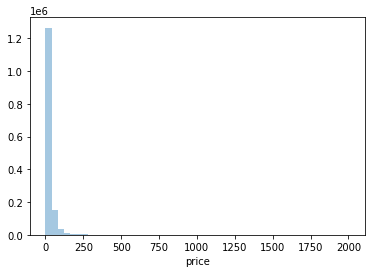

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6,4))
sns.distplot(y_train_df, kde=False)

- Price 칼럼을 로그 값으로 변환한 뒤 분포도 다시 살펴보기

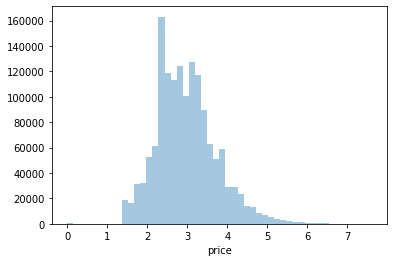

In [48]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

- 데이터 세트의 price 칼럼을 원래 값에서 로그로 변환된 값으로 변경

In [49]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

- 다른 피처의 값도 살펴보기

In [50]:
print('Shipping 값 유형:\n', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형:\n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형:
 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형:
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


&rarr; item_description 칼럼은 Null 값은 별로 없지만, description에 대한 별도 설명이 없는 경우 'No description yet' 값으로 돼 있음

In [51]:
boolean_cond= mercari_df['item_description']=='No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

&rarr; 'No description yet'의 경우도 Null과 마찬가지로 의미 있는 속성값으로는 사용될 수 없으므로 적절한 값으로 변경  
- category_name은 텍스트이므로 피처 추출 시 tokenizer를 '/'로 하여 단어를 분리해 벡터화할 수도 있지만, 여기서는 category_name의 '/'를 기준으로 단어를 토큰화해 각각 별도의 피처로 저장하고 이를 이용해 알고리즘을 학습
- category_name 칼럼을 '/'를 기준으로 대, 중, 소분류를 효과적으로 분리해 내기 위해 별도의 `split_cat()` 함수를 생성하고 이를 DataFrame의 apply lambda 식에 적용
    - Null 값을 약 6300여 건을 가지고 있으므로 유의하면서 분리해야 함
    - 파이썬은 문자열에 `split(tokenizer문자)` 함수를 호출하면 tokenizer 문자에 따라 문자열을 분리해 리스트로 반환
    - Null이 아닌 경우에 `split('/')`를 이용해 대, 중, 소 분류를 분리
    - category name이 Null일 경우에는 `split()` 함수가 Error를 발생하므로 이 Error를 except catch하여 대, 중, 소 분류 모두 'Other Null' 값 부여
- 대, 중, 소 칼럼은 mercari_df에서 cat_dae, cat_jung, cat_so로 부여
    - 한 가지 고민해야 할 점은 판다스의 apply lambda로 반환되는 데이터 세트가 리스트를 요소로 가지고 있는데, 이를 다시 cat_dae, cat_jung, cat_so의 DataFrame으로 분리해야 한다는 것
    - zip과 *를 apply lambda 식에 적용하면 여러 개의 칼럼으로 간단하게 분리 가능

In [52]:
# apply lambda에서 호출되는 대,중,소 분할 함수 생성, 대,중,소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

# 위의 split_cat()을 apply lambda에서 호출하여 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
                        zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류, 소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형: \n', mercari_df['cat_dae'].value_counts())
print('중분류 갯수: ', mercari_df['cat_jung'].nunique())
print('소분류 갯수: ', mercari_df['cat_so'].nunique())

대분류 유형: 
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 갯수:  114
소분류 갯수:  871


- brand_name, category_name, item_description 칼럼의 Null 값은 일괄적으로 'Other Null'로 동일하게 변경

In [53]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

# 각 컬럼별로 Null값 건수 확인. 모두 0가 나와야 합니다.
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화
- Mercari Price Suggestion에 이용되는 데이터 세트는 문자열 칼럼이 많음
- 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼을 선별
- 먼저 이 피처를 어떤 방식으로 변환할지 검토한 후에 추후에 일괄적으로 전체 속성의 변환 작업을 적용
- 선형 회귀 모델과 회귀 트리 모델을 모두 적용할 예정이며, 특히 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용
- 피처 벡터화의 경우는 비교적 짧은 텍스트의 경우는 Count 기반의 벡터화를, 긴 텍스트는 TD-IDF 기반의 벡터화를 적용

In [54]:
# brand_name
print('brand name 의 유형 건수 : ', mercari_df['brand_name'].nunique())
print('brand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name 의 유형 건수 :  4810
brand name sample 5건: 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


&rarr; 대부분 명료한 문자열로 돼 있음. 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환을 적용하면 됨  
&rarr; 종류가 4810건으로 원-핫 인코딩으로 변환하기에 다소 많아 보이나 본 예제의 ML 모델 구축상 큰 문제는 없음

In [55]:
# name
print('name 의 종류 갯수 : ', mercari_df['name'].nunique())
print('name sample 7건: \n', mercari_df['name'][:7])

name 의 종류 갯수 :  1225273
name sample 7건: 
 0    MLB Cincinnati Reds T Shirt Size XL
1       Razer BlackWidow Chroma Keyboard
2                         AVA-VIV Blouse
3                  Leather Horse Statues
4                   24K GOLD plated rose
5       Bundled items requested for Ruie
6     Acacia pacific tides santorini top
Name: name, dtype: object


&rarr; 유형이 매우 많고, 적은 단어 위주의 텍스트 형태로 돼 있으므로 Count 기반으로 피처 벡터화 변환을 적용  
- cat_dae, cat_jung, cat_so 칼럼도 원-핫 인코딩을 적용
- shipping 칼럼은 배송비 무료 여부로서 0과 1, 두 가지 유형의 값을 가지고 있으며 item_condition_id는 상품 상태로서 1, 2, 3, 4, 5의 다섯 가지 유형의 값을 가지 있으므로 이 두 칼럼 모두 원-핫 인코딩을 적용

In [56]:
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 개수
print('item_description 평균 문자열 크기: ',mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기:  145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

&rarr; 비교적 크므로 해당 칼럼은 TF-IDF로 변환  
- 주요 칼럼을 인코딩 및 피처 벡터화 변환

In [57]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description 에 대한 피처 벡터화 변환 
tfidf_descp = TfidfVectorizer(max_features = 50000, ngram_range= (1,3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape: ', X_name.shape)
print('item_description vectorization shape: ',X_descp.shape)

name vectorization shape:  (1482535, 105757)
item_description vectorization shape:  (1482535, 50000)


- CountVectorizer, TfidfVectorizer가 `fit_transform()`을 통해 반환하는 데이터는 희소 행렬 형태임
- 희소 행렬 객체 변수인 X_name과 X_descp를 새로 결합해 새로운 데이터 세트로 구성해야 하고, 앞으로 인코딩 될 cat_dae, cat_jung, cat_so, brand_name, shipping, item_condition_id도 모두 X_name, X_descp와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 함
- 이를 위해서 이 인코딩 대상 칼럼도 밀집 행렬 행태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합하도록 함
- 사이킷런은 원-핫 인코딩을 위해 OneHotEncoder와 LabelBinarizer 클래스를 제공함
    - LabelBinarizer 클래스는 희소 행렬 형태의 원-핫 인코딩 변환을 지원함. 생성 시 `sparse_out=True`로 파라미터 설정해주기만 하면 됨
1. 모든 인코딩 대상 칼럼은 LabelBinarizer를 이용해 희소 행렬 형태의 원-핫 인코딩으로 변환
2. 개별 칼럼으로 만들어진 희소 행렬은 사이파이 패키지 sparse 모듈의 `hstack()` 함수를 이용해 결합
    - `hstack()` 함수는 희소 행렬을 손쉽게 칼럼 레벨로 결합할 수 있게 해줌



In [58]:
from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name= LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])

lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])

lb_shipping= LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae= lb_cat_dae.fit_transform(mercari_df['cat_dae'])

lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])

lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

- 제대로 변환됐는지 생성된 인코딩 데이터 세트의 타입과 shape 살펴보기

In [59]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand_shape:{0}, X_item_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'.format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand_shape:(1482535, 4810), X_item_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


&rarr; 인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입  
- 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 `hstack()`을 이용해 모두 결합
- 결합된 데이터는 Mercari Price Suggestion을 위한 기반 데이터 세트로 사용되는데, 여기서는 결합한 데이터의 타입과 크기만 확인하고 메모리에서 삭제
    - 비교적 많은 메모리를 잡아먹기 때문에 개인용 PC에서 메모리 오류가 발생할 수 있기에 `del '객체 변수명'`과 `gc.collect()`로 결합 데이터를 메모리에서 삭제
- 추후에 다양한 모델을 적용하므로 그때마다 다시 결합해 해당 데이터 세트를 이용

In [60]:
from  scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합 
X_features_sparse= hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제 
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


294

### 릿지 회귀 모델 구축 및 평가
- 여러 알고리즘 모델과 희소 행렬을 변환하고 예측 성능을 비교하면서 테스트를 수행할 것이므로 수행에 필요한 로직을 함수화
- 먼저 모델을 평가하는 평가(Evaluation) 로직을 함수화
- 적용할 평가 지표는 캐글에서 제시한 RMSLE(Root Mean Square Logarithmic Error) 방식으로 함
    - RMSLE는 RMSE와 유사하나 오류 값에 로그를 취해 RMSE를 구하는 방식임
    - 낮은 가격(price)보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해서 이 방식을 도입함
- 별도의 RMSLE를 구하는 함수를 `rmsle((y, y_pred)`로 생성
    - 한 가지 주의해야 할 사항은 학습할 모델이 사용할 price 값은 로그 값으로 변환된 price 값이므로 다시 로그의 역변환인 지수(Exponential) 변환을 수행해 원복해야 함
- 원복된 데이터를 기반으로 RMSLE를 적용할 수 있도록` evaluate_org_price(y_test, preds)` 함수 생성

In [61]:
def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산 
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds): 
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1으로 원복 필요 
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

- 학습용 데이터를 생성하고, 모델을 학습/예측하는 로직을 별도의 함수로 만들기
    - `model train_predict()` 함수는 model 인자로 사이킷런의 회귀 estimator 객체를, matrix_list 인자로 최종 데이터 세트로 결합할 희소 행렬 리스트를 가짐


In [62]:
import gc 
from  scipy.sparse import hstack

def model_train_predict(model,matrix_list):
    # scipy.sparse 모듈의 hstack을 이용하여 희소 행렬 결합
    X = hstack(matrix_list).tocsr()     
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], 
                                                        test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train 
    gc.collect()
    
    return preds, y_test

- 이를 이용해 먼저 Ridge를 이용해 Mercari Price의 회귀 예측 수행
- 수행 전에 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보기

In [63]:
linear_model = Ridge(solver="lsqr", fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값: ', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값:  0.5023727038010556
Item Description을 포함한 rmsle 값:  0.47121951434336345


&rarr; Item Description을 포함했을 때 rmsle 값이 많이 감소함. Item description 영향이 중요함을 알 수 있음

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가
- LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 앙상블(Ensemble) 방식으로 섞어서 최종 회귀 예측값을 평가
- 먼저 LightGBM으로 회귀 수행
    - n_estimators를 1000 이상 증가시키면 예측 성능은 조금 좋아지는데, 수행 시간이 PC에서 1시간 이상 걸림
    - n_estimators를 200으로 작게 설정하고 예측 성능 측정

In [64]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값: ',  evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값:  0.4571958024426099


&rarr; 앞 예제의 Ridge보다 예측 성능이 더 나아짐  
- 다음으로 이렇게 구한 LightGBM의 예측 결괏값과 위에서 구한 Ridge의 예측 결괏값을 서로 앙상블해 최종 예측 결괏값 도출
    - LightGBM 결괏값에 0.45를 곱하고 Ridge 결괏값에 0.55를 곱한 값을 서로 합해 최종 예측 결괏값으로 함(임의로 산정)

In [65]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle 값: ', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle 값:  0.45072592143293


&rarr; 간단한 앙상블 방식으로 예측 성능 더 개선함